In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [1]:
%load_ext autoreload
%autoreload
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

from datasets.kitti_raw_monosf import KITTI_Raw_KittiSplit_Train, KITTI_Raw_KittiSplit_Valid, CarlaDataset
from models.CNet import CNet
from augmentations import Augmentation_SceneFlow

from losses import _adaptive_disocc_detection

In [2]:
%autoreload
args = {
    'batch_size' : 1,
    'num_workers' : 2,
    'epochs': 1, 
    'lr': 2e-4,
    'momentum': 0.9,
    'beta': 0.999,
    'weight_decay': 0.0,
    'train': True,
    'cuda': True,
    'debug': False,
    'evaluation': False,
    'finetuning': False,
}

data_root = '/external/datasets/kitti_data_jpg/'
# train_dataset = KITTI_Raw_KittiSplit_Train(args={}, root=data_root, num_examples=100)
train_dataset = CarlaDataset({'baseline': 0.075}, data_root='/external/datasets/carla_stereo/Town01/')
# train_loader = DataLoader(train_dataset, batch_size=args['batch_size'], num_workers=args['num_workers'], shuffle=True, pin_memory=True)
# val_dataset = KITTI_Raw_KittiSplit_Valid(args={}, root=data_root)
# val_loader = DataLoader(val_dataset, batch_size=args['batch_size'], num_workers=args['num_workers'], shuffle=False, pin_memory=True)

ego_trans: tensor([[ 1.0000e+00,  2.7561e-04,  2.5185e-04, -1.6695e-01],
        [-2.7561e-04,  1.0000e+00,  5.2053e-06,  6.8414e-02],
        [-2.5185e-04, -5.2747e-06,  1.0000e+00,  6.4070e-02],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],
       dtype=torch.float64)
input_k_l1: tensor([[707.4918,   0.0000, 477.0000],
        [  0.0000, 707.4918, 165.0000],
        [  0.0000,   0.0000,   1.0000]])
input_k_r1: tensor([[707.4918,   0.0000, 477.0000],
        [  0.0000, 707.4918, 165.0000],
        [  0.0000,   0.0000,   1.0000]])
input_k_l2: tensor([[707.4918,   0.0000, 477.0000],
        [  0.0000, 707.4918, 165.0000],
        [  0.0000,   0.0000,   1.0000]])
input_k_r2: tensor([[707.4918,   0.0000, 477.0000],
        [  0.0000, 707.4918, 165.0000],
        [  0.0000,   0.0000,   1.0000]])
input_size: tensor([ 375., 1242.])


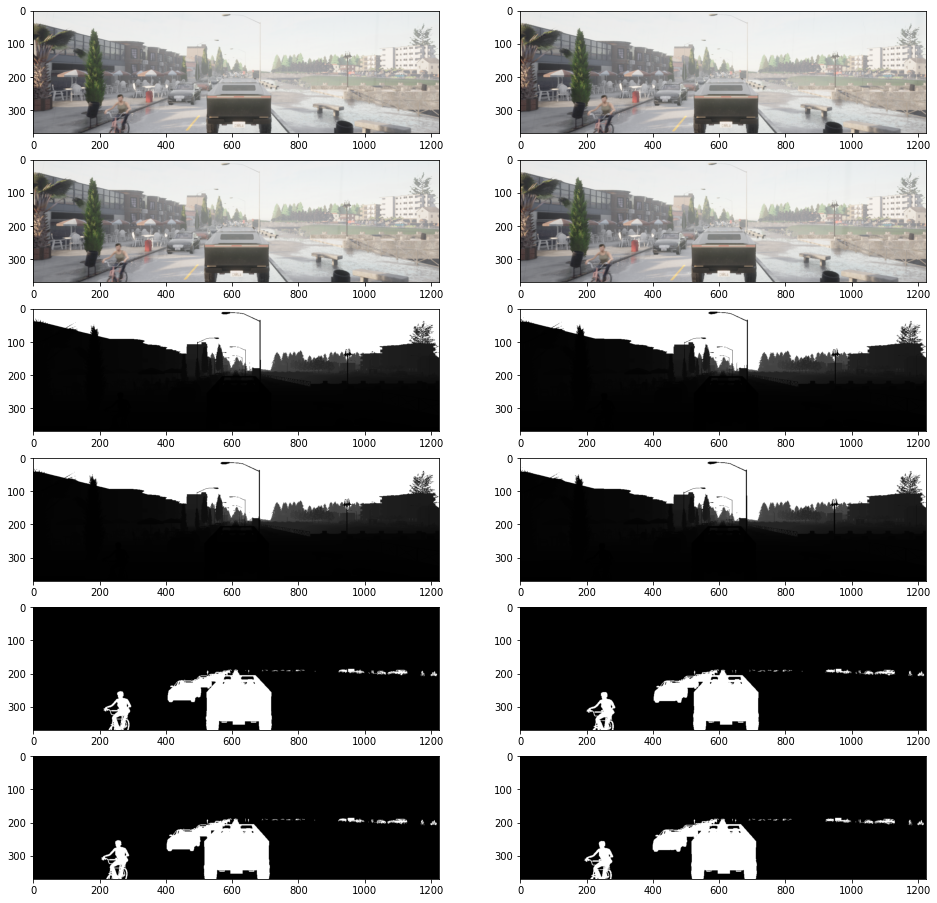

In [33]:
fig = plt.figure(figsize=(16, 16))
r, c = 6, 2
for i, (k, v) in enumerate(train_dataset[91].items()):
    if type(v) == float:
        continue
    elif len(v.shape) == 3:
        fig.add_subplot(r, c, i+1)
        cmap = None
        img = v.permute(1, 2, 0)
        if img.shape[-1] == 1:
            img = img.squeeze()
            cmap = 'gray'
        plt.imshow(img, cmap=cmap)
    else:
        print(f"{k}: {v}")

In [3]:
%autoreload 

augmentation = Augmentation_SceneFlow(args)
model = CNet(args)

if args['cuda']:
    print(torch.device('cuda:0'))
    augmentation = augmentation.cuda()
    model = model.cuda()
    
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(num_params)

# optimizer = Adam(model.parameters(), lr=args['lr'], betas=[args['momentum'], args['beta']], weight_decay=args['weight_decay'])

cuda:0
77273490


In [4]:
from time import time

train_loader = DataLoader(train_dataset, batch_size=1, num_workers=4, pin_memory=True)

start = time()
for i, data in enumerate(train_loader):
    for k, v in data.items():
        data[k] = v.cuda()
        
    data = augmentation(data)
    
    if i == 100:
        print((time() - start) / (i+1))
        break

0.045832473452728575


In [43]:
model(data)

TypeError: run_pwc() takes 6 positional arguments but 8 were given

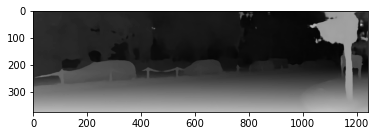

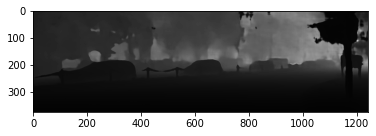

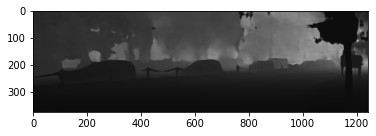

In [29]:
%autoreload
from losses import _disp2depth_kitti_K, _apply_disparity

disp = torch.tensor(plt.imread('../PSMNet/Test_disparity.png') / 255.)
plt.imshow(disp, cmap='gray')
plt.show()
depth_img = _disp2depth_kitti_K(disp, torch.tensor([721.5377])).squeeze()
depth_img_r = _apply_disparity(depth_img.unsqueeze(0).unsqueeze(0), disp.unsqueeze(0).unsqueeze(0))
plt.imshow(depth_img, cmap='gray')
plt.show()
plt.imshow(depth_img_r.squeeze(), cmap='gray')
plt.show()

In [39]:
# DEBUG
import pynvml
from pynvml import nvmlInit, nvmlDeviceGetHandleByIndex, nvmlDeviceGetMemoryInfo
nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print(f'total    : {info.total / (1024**3)} Gb')
print(f'free     : {info.free / (1024**3)} Gb')
print(f'used     : {info.used / (1024**3)} Gb')

total    : 7.92620849609375 Gb
free     : 5.755859375 Gb
used     : 2.17034912109375 Gb


In [5]:
%autoreload
start = time.time()
for i, data_dict in enumerate(train_loader):
    # Get input and target tensor keys
    input_keys = list(filter(lambda x: "input" in x, data_dict.keys()))
    target_keys = list(filter(lambda x: "target" in x, data_dict.keys()))
    tensor_keys = input_keys + target_keys

    # Possibly transfer to Cuda
    if args['cuda']:
        for key, value in data_dict.items():
            if key in tensor_keys:
                data_dict[key] = value.cuda(non_blocking=True)

    if augmentation is not None:
        with torch.no_grad():
            data_dict = augmentation(data_dict)
        
    x = model(data_dict)
    if i == 9:
        print(f"5 iterations took {time.time() - start}s")
        break

5 iterations took 4.380586862564087s


In [33]:
flow_s = torch.rand((1, 2, 3, 3))
flow_d = torch.rand((1, 2, 3, 3))
flow_cam = torch.rand((1, 2, 3, 3))
rigidity_mask = torch.randint(0, 2, (1, 1, 3, 3)).type_as(flow_s)

loss_static = torch.norm(flow_s * rigidity_mask, p=2)
loss_dynamic = torch.norm(flow_d * (1-rigidity_mask), p=2)
loss_static + loss_dynamic

torch.norm(flow_cam-flow_s, dim=1)

tensor([[[[0.0888, 0.8093, 0.5732],
          [0.3487, 0.5563, 0.5801],
          [0.8364, 0.3219, 0.6261]]]])
tensor([[[0.0888, 0.8093, 0.5732],
         [0.3487, 0.5563, 0.5801],
         [0.8364, 0.3219, 0.6261]]])


In [78]:
from utils.sceneflow_util import projectSceneFlow2Flow

# mask loss function

# optical flow losses
optical_flows = [projectSceneFlow2Flow(data_dict['input_k_l1'], sf, disp) for (sf, disp) in zip(x['flow_f'], x['disp_l1'])]

[torch.Size([1, 2, 256, 832]), torch.Size([1, 2, 128, 416]), torch.Size([1, 2, 64, 208]), torch.Size([1, 2, 32, 104]), torch.Size([1, 2, 16, 52])]


In [45]:
# create consistency loss functions
if data_dict:
    del data_dict
if x:
    del x
torch.cuda.empty_cache()

In [55]:
def train_one_epoch(model, dataloader, optimizer, augmentations):

  model.train()

  for i, data in enumerate(dataloader):
    continue

  return

In [58]:
for epoch in range(args['epochs']):
    loss_one_epoch = train_one_epoch(model, dataloader, optimizer, augmentations=augmentation)
    optimizer.zero_grad()
    loss_one_epoch.backward()
    

NameError: name 'optimizer' is not defined